In [ ]:
import numpy as np
import cv2
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords

from typing import Tuple, List, Dict, Union

%matplotlib inline

## Loading the dataset

In [ ]:
#nusc = NuScenes(version='v1.0-mini',dataroot='/content/drive/My Drive/AI_S/ML/NuScenes/v1.0-mini')
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 10.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


## Obtaining Scene

In [ ]:
# Select Scene 9
my_scene = nusc.scene[9]
my_scene

{'description': 'Night, peds in sidewalk, peds cross crosswalk, scooter, PMD, difficult lighting',
 'first_sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'last_sample_token': 'abf3d91d3c28407e80e3334fe89c03cb',
 'log_token': '8fefc430cbfa4c2191978c0df302eb98',
 'name': 'scene-1100',
 'nbr_samples': 40,
 'token': 'e233467e827140efa4b42d2b4c435855'}

In [ ]:
# Obtain First sample token from the scene
first_sample_token = my_scene['first_sample_token']

## Obtaining sample from Scene

In [ ]:
# Get sample from token
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'anns': ['9ca2a9ab9b5041278eea928681e09d89',
  '9dfee0c127f548acb80bf95610437acb',
  'b2222d3c49c447ba91247501e97d772b',
  '723bee443cf6433a95293aac161590d5',
  '29d4a8be2e91426da373d2b3b36302d7',
  '53242fa89307473fb78e35492e638856',
  '5b5c0d29afd546038a828c5376e7812f',
  '1167ef49543546d5a5b8d72893194e50',
  'e9a0946245ea43bbba0e3ff4e0459693',
  'c8d0d58bc9454ca8992e7eb27febda09',
  'cadc01f06d054f6589f96a6b1883e6a6',
  '4c82d383f7f54af38612ecac4028698d',
  '318911c9e58c410285dabc3e5c13cb8b',
  'fedb34281be246299448d0647fb3b2df',
  'e23a1c2091954a5e95a58e640c461915',
  '1d157033eed84ca98ad7966abc40e165',
  'bada2928484242a4b4a55a5e26f727b1',
  '17d6e7b2b520493eaff9c559b08d7382',
  '4894b54b856841f5bc7957b641ebba6b',
  '63b7794e1e044d8c87321ea27ee58dc8',
  '0298f73c79f247e9bd04c44282ba60eb',
  'ce9fe32b49974f4092157b30d7f2c674',
  '31f0dc786d0b4f24b748d9d0ece7378f',
  'fb2873a3231945249b1fe1acf0cedf1d'],
 'data': {'CAM_BACK': 'd340a8d85c874b8d9e9ddf51a82a5908',
  'CAM_BACK_LEFT': 'c

## Obtaining a instance 

{'attribute_tokens': ['c3246a1e22a14fcb878aa61e69ae3329'],
 'category_name': 'vehicle.car',
 'instance_token': 'ca291f5d8bf7447ca85d6a768808246d',
 'next': '0f0e346608004f799d7f68d71361a171',
 'num_lidar_pts': 28,
 'num_radar_pts': 0,
 'prev': '',
 'rotation': [0.9473110943049808, 0.0, 0.0, -0.3203149865471482],
 'sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'size': [1.869, 4.4, 1.632],
 'token': '1d157033eed84ca98ad7966abc40e165',
 'translation': [1303.661, 919.222, 0.064],
 'visibility_token': '4'}

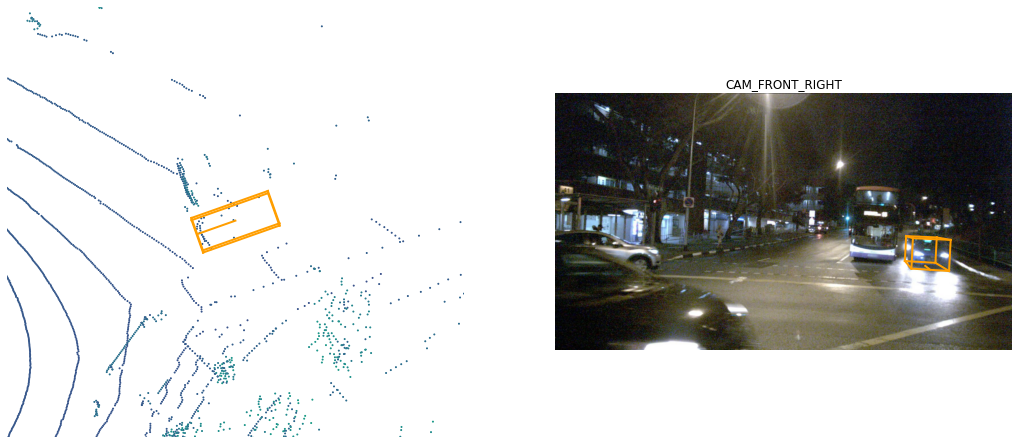

In [ ]:
# Obtain the token from an instance in the sample
my_annotation_token = my_sample['anns'][15] #23
#gets sample ann from token
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
nusc.render_annotation(my_annotation_token)
my_annotation_metadata

## Obtaining a sample from a Camera

The cameta dictionary is: 
{'token': '4a85ae2a6329487abed596b0b7b6dfa4', 'sample_token': 'a480496a5988410fbe3d8ed6c84da996', 'ego_pose_token': '4a85ae2a6329487abed596b0b7b6dfa4', 'calibrated_sensor_token': '302e35d6ff604f17adf2ccdebce473d1', 'timestamp': 1542800987920339, 'fileformat': 'jpg', 'is_key_frame': True, 'height': 900, 'width': 1600, 'filename': 'samples/CAM_FRONT_RIGHT/n015-2018-11-21-19-38-26+0800__CAM_FRONT_RIGHT__1542800987920339.jpg', 'prev': '', 'next': 'd86cb7c0403c4f81a34648193796fa92', 'sensor_modality': 'camera', 'channel': 'CAM_FRONT_RIGHT'}


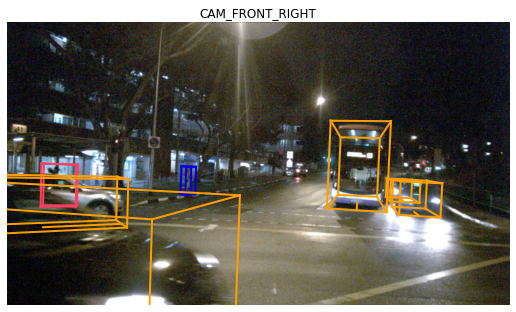

In [ ]:
# Get camera to use
sensor_camera = get_camera_data(my_annotation_metadata['token'])
print("Sensor camera: ",sensor_camera)

# Sample data from Sensor
cam_data = nusc.get('sample_data', my_sample['data'][sensor_camera])
# Render the current scene
nusc.render_sample_data(cam_data['token'])
# Print the dictionary
print('The camera dictionary is: \n{}'.format(cam_data))

## Transformation instances from the current camera sensor

In [ ]:
#get_2d_boxes(sample_data_token: str, visibilities: List[str]) -> List[OrderedDict]:

# Get the calibrated sensor and ego pose record to get the transformation matrices.
# From camera to ego
cs_rec = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
# From ego to world coordinate frame
pose_rec = nusc.get('ego_pose', cam_data['ego_pose_token'])
# Camera intrinsic parameters
camera_intrinsic = np.array(cs_rec['camera_intrinsic'])

## Printing the instance's target attributes

In [ ]:
# Get the box in global coordinates from sample ann token 
box = nusc.get_box(my_annotation_metadata['token'])
print("The target's label is: \n{}".format(box))
print('The number of lidar points hitting the target are: {}'.format(my_annotation_metadata['num_lidar_pts']))
my_annotation_metadata

The target's label is: 
label: nan, score: nan, xyz: [1303.66, 919.22, 0.06], wlh: [1.87, 4.40, 1.63], rot axis: [0.00, 0.00, -1.00], ang(degrees): 37.36, ang(rad): 0.65, vel: nan, nan, nan, name: vehicle.car, token: 1d157033eed84ca98ad7966abc40e165
The number of lidar points hitting the target are: 28


{'attribute_tokens': ['c3246a1e22a14fcb878aa61e69ae3329'],
 'category_name': 'vehicle.car',
 'instance_token': 'ca291f5d8bf7447ca85d6a768808246d',
 'next': '0f0e346608004f799d7f68d71361a171',
 'num_lidar_pts': 28,
 'num_radar_pts': 0,
 'prev': '',
 'rotation': [0.9473110943049808, 0.0, 0.0, -0.3203149865471482],
 'sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'size': [1.869, 4.4, 1.632],
 'token': '1d157033eed84ca98ad7966abc40e165',
 'translation': [1303.661, 919.222, 0.064],
 'visibility_token': '4'}

## Mapping the Box from World coordinate to Camera coordinate

In [ ]:
# Mapping the box from world coordinate-frame to camera sensor
# Move them to the ego-pose frame.
box.translate(-np.array(pose_rec['translation']))
box.rotate(Quaternion(pose_rec['rotation']).inverse)

# Move them to the calibrated sensor frame.
box.translate(-np.array(cs_rec['translation']))
box.rotate(Quaternion(cs_rec['rotation']).inverse)

## Filter the box for data in Z < 0 (behind the camera)

In [ ]:
# Filter out the corners that are not in front of the calibrated sensor.
# 8 corners of the 3d bounding box
corners_3d = box.corners()
# corners that are behind the sensor are removed
in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
corners_3d = corners_3d[:, in_front]

In [ ]:
# Project 3d box to 2d.
corner_coords = view_points(corners_3d, camera_intrinsic, True).T[:, :2].tolist()
print("Box number of coords: {}".format(np.array(corner_coords).shape))

Box number of coords: (8, 2)


## Plot the results

min_x: 1225
min_y: 499
max_x: 1386
max_y: 622


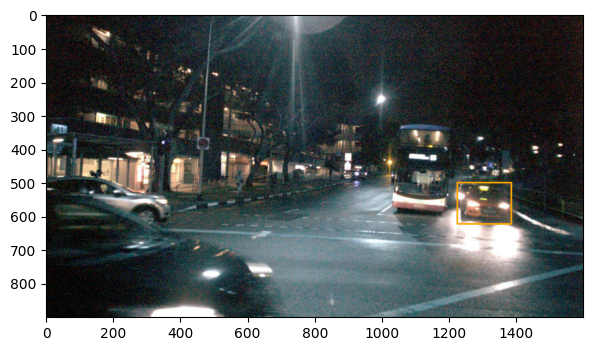

In [ ]:
# Extract coorners
# Filter points that are outside the image
final_coords = post_process_coords(corner_coords)

min_x, min_y, max_x, max_y = [int(coord) for coord in final_coords]

print("min_x: {}".format(min_x))
print("min_y: {}".format(min_y))
print("max_x: {}".format(max_x))
print("max_y: {}".format(max_y))

# Load image from dataroot
img_path = osp.join(nusc.dataroot, cam_data['filename'])
img = cv2.imread(img_path, 1)

# Draw rectangle on image with coords
img_r = cv2.rectangle(img, (min_x,min_y),(max_x,max_y),(255, 165, 0) , 3)

plt.figure(figsize=(12, 4), dpi=100)
plt.imshow(img_r)
plt.show()

# Get Camera data
This method brings the Camera in which the box is located.

In [ ]:
def get_camera_data(annotation_token: str,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY):
    
    """
    Given an annotation token (3d detection in world coordinate frame) this method 
    returns the camera in which the annotation is located. If the box is splitted 
    between 2 cameras, it brings the first one found.
    :param annotation_token: Annotation token.
    :return camera data.
    """
    #Get sample annotation
    ann_record = nusc.get('sample_annotation', annotation_token)

    sample_record = nusc.get('sample', ann_record['sample_token'])
  
    boxes, cam = [], []

    #Stores every camera
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]

    #Try with every camera a match for the annotation
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                                selected_anntokens=[annotation_token])
        if len(boxes) > 0:
            break  # Breaks if find an image that matches
    assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"
    
    #cam = sample_record['data'][cam]

    return cam

# Mapping Target to Camera

This short method maps a label in the world-coordinate frame to the interest-camera coordinate frame.

In [ ]:
def target_to_cam(camera_token: str,
                  annotation_token: str,
                  camera_channel: str = 'CAM_FRONT'):
    """
    Given an annotation token (3d detection in world coordinate frame) and camera sample_data token,
    transform the label from world-coordinate frame to camera.
    :param camera_channel: Camera channel name, e.g. 'CAM_FRONT'.
    :param camera_token: Camera sample_data token.
    :param annotation_token: Camera sample_annotation token.
    :return box with the labels for the 3d detection task.
    """
    
    # Camera sample        
    cam_data = nusc.get('sample_data', camera_token) # Sample camera info
        
    # From camera to ego
    cs_rec = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    # Transformation metadata from ego to world coordinate frame
    pose_rec = nusc.get('ego_pose', cam_data['ego_pose_token'])
    
    # Obtain the annotation from the token
    annotation_metadata =  nusc.get('sample_annotation', annotation_token)
    
    # Obtain box parameters
    box = nusc.get_box(annotation_metadata['token'])
                                           
    # Move them to the ego-pose frame.
    box.translate(-np.array(pose_rec['translation']))
    box.rotate(Quaternion(pose_rec['rotation']).inverse)

    # Move them to the calibrated sensor frame.
    box.translate(-np.array(cs_rec['translation']))
    box.rotate(Quaternion(cs_rec['rotation']).inverse)
    
    return box

In [ ]:
new_box = target_to_cam(cam_data['token'], my_annotation_token, camera_channel = 'CAM_FRONT_RIGHT')
print(new_box)

label: nan, score: nan, xyz: [8.20, 0.99, 21.16], wlh: [1.87, 4.40, 1.63], rot axis: [-0.48, -0.64, 0.60], ang(degrees): -127.93, ang(rad): -2.23, vel: nan, nan, nan, name: vehicle.car, token: 1d157033eed84ca98ad7966abc40e165


# Mapping Lidar and Radar point Cloud to interest camera

In [ ]:
def map_pointcloud_to_image_(bbox,
                             pointsensor_token: str,
                             camera_token: str,
                             min_dist: float = 1.0,
                             visualize: bool = False) -> Tuple:
        """
        Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image
        plane.
        :param bbox: object coordinates in the current image.
        :param pointsensor_token: Lidar/radar sample_data token.
        :param camera_token: Camera sample_data token.
        :param min_dist: Distance from the camera below which points are discarded.
        :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
        """
        cam = nusc.get('sample_data', camera_token) # Sample camera info
        pointsensor = nusc.get('sample_data', pointsensor_token) # Sample point cloud
        # pcl_path is the path from root to the pointCloud file
        pcl_path = osp.join(nusc.dataroot, pointsensor['filename']) 
        # Open the pointCloud path using the Lidar or Radar class
        if pointsensor['sensor_modality'] == 'lidar':
            # Read point cloud with LidarPointCloud (4 x samples) --> X, Y, Z and intensity
            pc = LidarPointCloud.from_file(pcl_path)
            # To access the points pc.points
        else:
            # Read point cloud with LidarPointCloud (18 x samples) --> 
            # https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/utils/data_classes.py#L296
            pc = RadarPointCloud.from_file(pcl_path)
                        
        # Open image of the interest camera
        im = Image.open(osp.join(nusc.dataroot, cam['filename']))

        # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
        # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
        cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token']) # Transformation matrix of pointCloud
        # Transform the Quaternion into a rotation matrix and use method rotate in PointCloud class to rotate
        # Map from the laser sensor to ego_pose
        # The method is a dot product between cs_record['rotation'] (3 x 3) and points (3 x points)
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        # Add the traslation vector between ego vehicle and sensor
        # The method translate is an addition cs_record['translation'] (3,) and points (3 x points)
        pc.translate(np.array(cs_record['translation']))

        # Second step: transform to the global frame.
        poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        # Same step as before, map from ego_pose to world coordinate frame
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
        pc.translate(np.array(poserecord['translation']))

        # Third step: transform into the ego vehicle frame for the timestamp of the image.
        poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
        # Same step as before, map from world coordinate frame to ego vehicle frame for the timestamp of the image.
        pc.translate(-np.array(poserecord['translation']))
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

        # Fourth step: transform into the camera.
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        # Same step as before, map from ego at camera timestamp to camera
        pc.translate(-np.array(cs_record['translation']))
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

        # Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]
        
        # Save original points (X, Y and Z) coordinates
        ori_points = pc.points[:3, :]
        
        # Retrieve the color from the depth.
        coloring = depths
        
        '''
        if render_intensity:
            assert pointsensor['sensor_modality'] == 'lidar', 'Error: Can only render intensity for lidar!'
            # Retrieve the color from the intensities.
            # Performs arbitary scaling to achieve more visually pleasing results.
            intensities = pc.points[3, :]
            intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))
            intensities = intensities ** 0.1
            intensities = np.maximum(0, intensities - 0.5)
            coloring = intensities
        else:
            # Retrieve the color from the depth.
            coloring = depths
        '''

        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        # Normalization means to divide the X and Y coordinates by the depth
        # The output dim (3 x n_points) where the 3rd row are ones.
        points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
        
        # bounding box coordinates
        min_x, min_y, max_x, max_y = [int(points_b) for points_b in bbox]

        # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
        # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
        # casing for non-keyframes which are slightly out of sync.
        # Create a mask of bools the same size of depth points
        mask = np.ones(depths.shape[0], dtype=bool)
        # Keep points that are at least 1m in front of the camera 
        mask = np.logical_and(mask, depths > min_dist)
        # Keep points such as X coordinate is bigger than bounding box minimum coordinate
        mask = np.logical_and(mask, points[0, :] > min_x + 1)
        # remove points such as X coordinate is bigger than bounding box maximum coordinate
        mask = np.logical_and(mask, points[0, :] < max_x - 1)
        # Keep points such as Y coordinate is bigger than bounding box minimum coordinate
        mask = np.logical_and(mask, points[1, :] > min_y + 1)
        # remove points such as Y coordinate is bigger than bounding box maximum coordinate
        mask = np.logical_and(mask, points[1, :] < max_y - 1)
        # Keep only the interest points
        points = points[:, mask]
        coloring = coloring[mask]
        ori_points = ori_points[:, mask]
        
        if visualize:
            plt.figure(figsize=(9, 16))
            plt.imshow(im)
            plt.scatter(points[0, :], points[1, :], c = coloring, s = 5)
            plt.axis('off')
            
        return points, coloring, ori_points, im

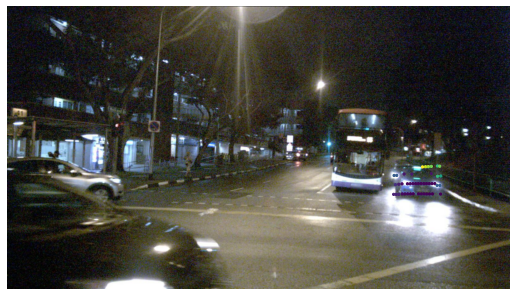

In [ ]:
sensor_laser = 'LIDAR_TOP'

# Sample data from Sensor
point_data = nusc.get('sample_data', my_sample['data'][sensor_laser])
# Method to map a point cloud to a particular bounding box
points, coloring, ori_points, im = map_pointcloud_to_image_(final_coords, point_data['token'], 
                                                            cam_data['token'], visualize = True)

In [ ]:
# Points in current image frame
print('The shape of the points in the image are: {}'.format(points.shape))
# Depths of the points in the image frame
print('The shape of the depths in the image are: {}'.format(coloring.shape))
# Filtered points in camera coordinates
print('The shape of the original points in the camera frame are: {}'.format(ori_points.shape))

The shape of the points in the image are: (3, 585)
The shape of the depths in the image are: (585,)
The shape of the original points in the camera frame are: (3, 585)
